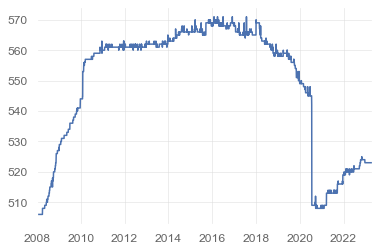

In [67]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import datetime
from tqdm import tqdm
import pandas_ta as ta



universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

In [72]:
help(ta.cfo)

Help on function cfo in module pandas_ta.momentum.cfo:

cfo(close, length=None, scalar=None, drift=None, offset=None, **kwargs)
    Chande Forcast Oscillator (CFO)
    
    The Forecast Oscillator calculates the percentage difference between the actual
    price and the Time Series Forecast (the endpoint of a linear regression line).
    
    Sources:
        https://www.fmlabs.com/reference/default.htm?url=ForecastOscillator.htm
    
    Calculation:
        Default Inputs:
            length=9, drift=1, scalar=100
        LINREG = Linear Regression
    
        CFO = scalar * (close - LINERREG(length, tdf=True)) / close
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The period. Default: 9
        scalar (float): How much to magnify. Default: 100
        drift (int): The short period. Default: 1
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
      

In [78]:
aapl = market_data.xs('AAPL',level=1)
ta.cfo(aapl['high'])


Date
2008-01-02         NaN
2008-01-03         NaN
2008-01-04         NaN
2008-01-07         NaN
2008-01-08         NaN
                ...   
2023-03-30    0.609890
2023-03-31    1.445522
2023-04-03    1.310696
2023-04-04    0.525454
2023-04-05   -0.997004
Name: CFO_9, Length: 3842, dtype: float64

In [79]:
squeeze_data ={}
for ticker in tqdm(P.columns.tolist()):
    try :
        df_ticker = market_data.xs(ticker,level=1)
        squeeze = ta.cfo(df_ticker['high']) + ta.cfo(df_ticker['low']) /2  - ta.cfo(df_ticker['close'])
        # squeeze = ta.stoch(df_ticker['high'],df_ticker['low'],df_ticker['close'],k=10,mamode='ema',d=25).iloc[:,0]
        squeeze_data[ticker] = squeeze
    except :
        pass

100%|██████████| 863/863 [04:46<00:00,  3.02it/s]


<Axes: >

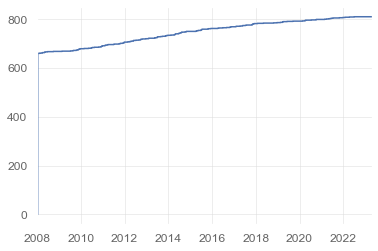

In [80]:
squeeze_data = pd.concat(squeeze_data,axis=1).reindex_like(P).ffill()
squeeze_data.count(1).plot()

C:\Users\marti\AppData\Local\Temp\ipykernel_60556\3805045238.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(25).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_60556\3805045238.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe     -0.564
Turnover    0.908
biais      -0.787
dtype: float64

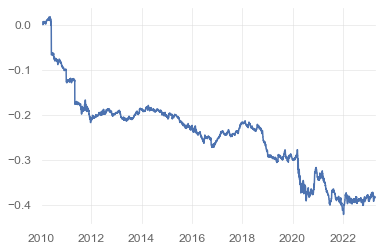

In [82]:
signal = squeeze_data[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(25).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.25] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)